# Random forest on single-cell RNA-seq data



In [63]:
library(randomForest)
library(varhandle) # pour la fonction unfactor qui annule la facheuse tendance qu'à R de tout convertir en factors...

## Acquisition et nettoyage des données

In [64]:
Data = read.table("GSE57872_GBM_data_matrix.txt", sep="\t")

In [65]:
for (i in 2:dim(Data)[2]){
    colnames(Data)[i]= as.character(Data[1,i])
}
for (i in 2:dim(Data)[1]){
    rownames(Data)[i]= as.character(Data[i,1])
}

colnames(Data)[1] = "Cells_name"
Data = Data[-1,] ; Data = Data[,-1]

In [66]:
#On retire les Cancer Stem Cells
CSC_cols = numeric(0)
for (i in 1:length(colnames(Data)) ){
    if (grepl("CSC", colnames(Data)[i]) || grepl("FCS", colnames(Data)[i]) || grepl("Tumor", colnames(Data)[i])) {CSC_cols = c(CSC_cols, i)}
}
Data = Data[-CSC_cols]

In [67]:
#On transpose le data frame pour avoir les gênes en colonnes et les cellules en lignes
df2 = data.frame(t(Data))
Data = df2

Data = unfactor(Data)

<br><br><br><br><br><br>


# Unsupervised Random Forest avec Addcl1 :

## Métaparamètres : 

In [68]:
nb_forests = 5 # nombre de forets
nb_trees = 500 # nombre d'arbres par forets
nb_cells = dim(Data)[1] # nombre de cellules (lignes du data frame)
nb_genes = dim(Data)[2] # nombre de gènes (colones du data frame)
mtry = sqrt(nb_genes) # nombre de variables (gènes) testés à chaque splits des arbres

## Addcl1

In [69]:
addcl1 = function(dat) {
        bootstrap = function(X)   { sample(X, replace=T) } 
        col_bootstrap = function(dat) { apply(dat,2, bootstrap) } #On bootstrap sur chaque colonne
        nrow <- dim(dat)[1];
        Classe <- rep(c(1,2),c(nrow,nrow) ) #Un vecteur contenant nb_obs 1 et nb_obs 2, les classes sur lesquelles la URF va travailler
        data.frame(cbind(Classe,rbind(dat,data.frame(col_bootstrap(dat)))))
    }

## VarImpPlot pour multi-forets
Adaptation du code source de VarImpPlot sur cette page pour le cas multi-forets (https://github.com/cran/randomForest/blob/master/R/varImpPlot.R)

In [70]:
varImpPlot_mult = function(imp, sort=TRUE,
                       n.var=min(30, nrow(imp)),
                       main=deparse(substitute(x)), ...) {
    if (ncol(imp) > 2) imp <- imp[, -(1:(ncol(imp) - 2))]
    nmeas = ncol(imp)
    if (nmeas > 1) {
        op = par(mfrow=c(1, 2), mar=c(4, 5, 4, 1), mgp=c(2, .8, 0),
                  oma=c(0, 0, 2, 0), no.readonly=TRUE)
        on.exit(par(op))
    }
    for (i in 1:nmeas) {
        ord <- if (sort) rev(order(imp[,i],
                                   decreasing=TRUE)[1:n.var]) else 1:n.var
        xmin <- if (colnames(imp)[i] %in%
                    c("IncNodePurity", "MeanDecreaseGini")) 0 else min(imp[ord, i])
        dotchart(imp[ord,i], xlab=colnames(imp)[i], ylab="",
                 main=if (nmeas == 1) main else NULL,
                 xlim=c(xmin, max(imp[,i])), ...)
    }
    if (nmeas > 1) mtext(outer=TRUE, side=3, text=main, cex=1.2)
    invisible(imp)
}

## Forêt


Call:
 randomForest(formula = factor(target) ~ ., data = DataRFsyn[,      -1], ntree = nb_trees, proximity = TRUE, mtry = mtry, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 77

        OOB estimate of  error rate: 0%
Confusion matrix:
    1   2 class.error
1 430   0           0
2   0 430           0

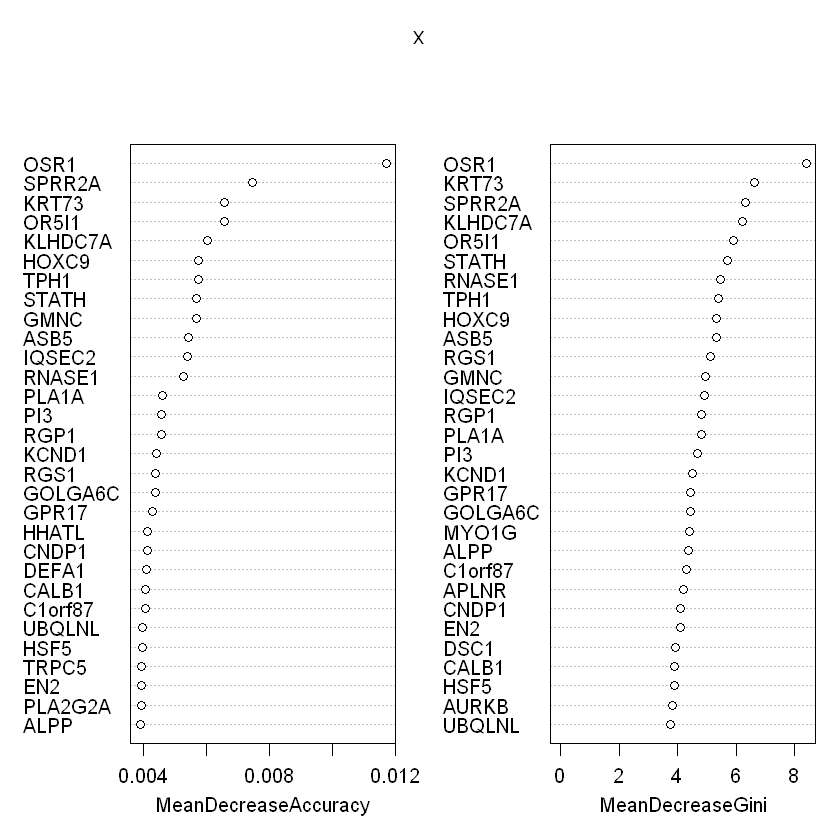

In [71]:
RFproxTotal = matrix(0, nb_cells, nb_cells)
RFimportance = matrix(0, nrow=nb_genes, ncol=4)
for (i in 1:nb_forests){
    DataRFsyn = addcl1(Data)
    target = DataRFsyn[,1]
    RF = randomForest(factor(target)~.,
                      data = DataRFsyn[,-1], 
                      ntree = nb_trees, 
                      proximity = TRUE, 
                      mtry = mtry, 
                      importance = TRUE) 
    
    RF$prox = RF$prox[1:nb_cells, 1:nb_cells]
    RFproxTotal = RFproxTotal + RF$prox
    RFimportance = RFimportance + (1/nb_forests)*(RF$importance)
}
RFproxTotal = RFproxTotal/nb_forests

RF
varImpPlot_mult(RFimportance)

## MDS

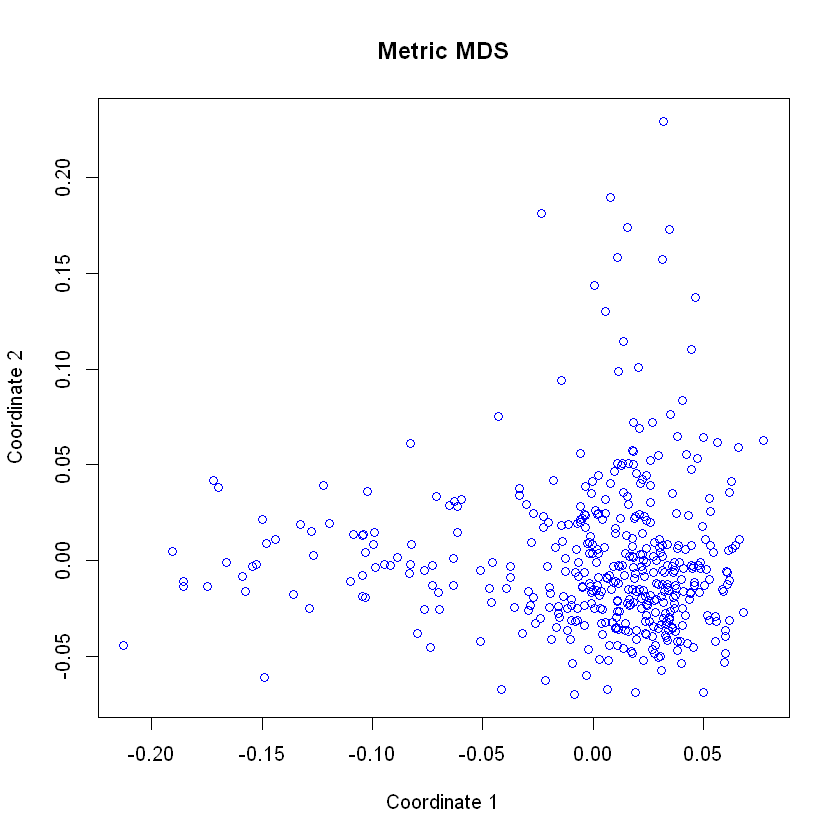

In [72]:
DISS = sqrt(1-RFproxTotal) #la matrice de dissimilarité de la random forest
MDS = cmdscale(DISS,eig=TRUE, k=2)
x <- MDS$points[,1]
y <- MDS$points[,2]
plot(x, y, xlab="Coordinate 1", ylab="Coordinate 2", 
  main="Metric MDS", col = "blue")

<br><br><br><br><br>
# On entraine la RF à différencier deux patients.

In [73]:
# Créé un dataframe contenant les données de deux patients à comparer.
# Les patiens disponibles sont : MGH26, MGH28, MGH29, MGH30, MGH31.
select_patients = function(Data, pat1 = 'MGH26', pat2 = 'MGH28'){
    not_pat_rows = numeric(0)
    for (i in 1:length(colnames(Data)) ){
        if ( !(grepl(pat1, rownames(Data)[i]) || grepl(pat2, rownames(Data)[i])) ) {not_pat_rows = c(not_pat_rows, i)}
    }
    return(Data[-not_pat_rows,])
}

## Addcl_pat

In [74]:
addcl_pat = function(dat, pat1 = 'MGH26', pat2 = 'MGH28'){
    nb_pat1 = 0 ; nb_pat2 = 0
    for (i in rownames(dat)) {
        if (grepl(pat1, i)) {nb_pat1 = nb_pat1 + 1}
        else {nb_pat2 = nb_pat2 +1}
    }
    Classe = rep( c(1,2),c(nb_pat1, nb_pat2) )
    data.frame( cbind(Classe, dat) )
}

In [75]:
Data_patients = select_patients(Data)

In [76]:
nb_forests_2 = 5 # nombre de forets
nb_trees_2 = 500 # nombre d'arbres par forets
nb_cells_2 = dim(Data_patients)[1] # nombre de cellules (lignes du data frame)
nb_genes_2 = dim(Data_patients)[2] # nombre de gènes (colones du data frame)
mtry_2 = sqrt(nb_genes_2) # nombre de variables (gènes) testés à chaque splits des arbres
pat1 = 'MGH26' ; pat2 = 'MGH28'


Call:
 randomForest(formula = factor(target) ~ ., data = DataRFsyn[,      -1], ntree = nb_trees_2, proximity = TRUE, mtry = mtry_2,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 77

        OOB estimate of  error rate: 0%
Confusion matrix:
    1  2 class.error
1 118  0           0
2   0 94           0

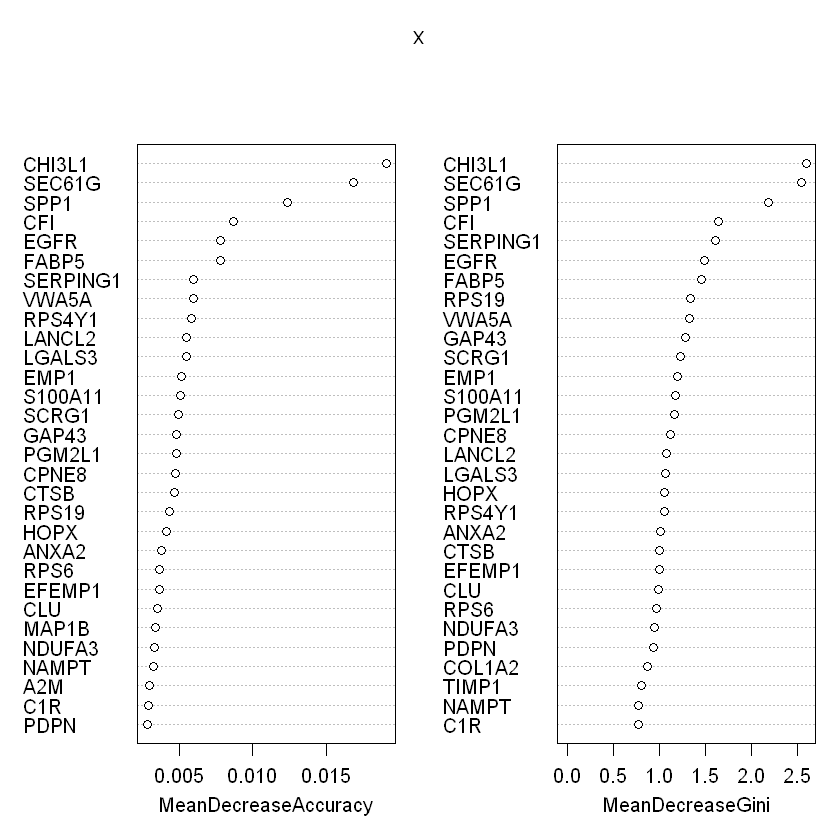

In [77]:
RFproxTotal = matrix(0, nb_cells_2, nb_cells_2)
RFimportance = matrix(0, nrow=nb_genes_2, ncol=4)
for (i in 1:nb_forests_2){
    DataRFsyn = addcl_pat(Data_patients, pat1, pat2)
    target = DataRFsyn[,1]
    RF = randomForest(factor(target)~.,
                      data = DataRFsyn[,-1], 
                      ntree = nb_trees_2, 
                      proximity = TRUE, 
                      mtry = mtry_2, 
                      importance = TRUE) 
    
    RF$prox = RF$prox[1:nb_cells_2, 1:nb_cells_2]
    RFproxTotal = RFproxTotal + RF$prox
    RFimportance = RFimportance + (1/nb_forests_2)*(RF$importance)
}
RFproxTotal = RFproxTotal/nb_forests_2

RF
varImpPlot_mult(RFimportance)

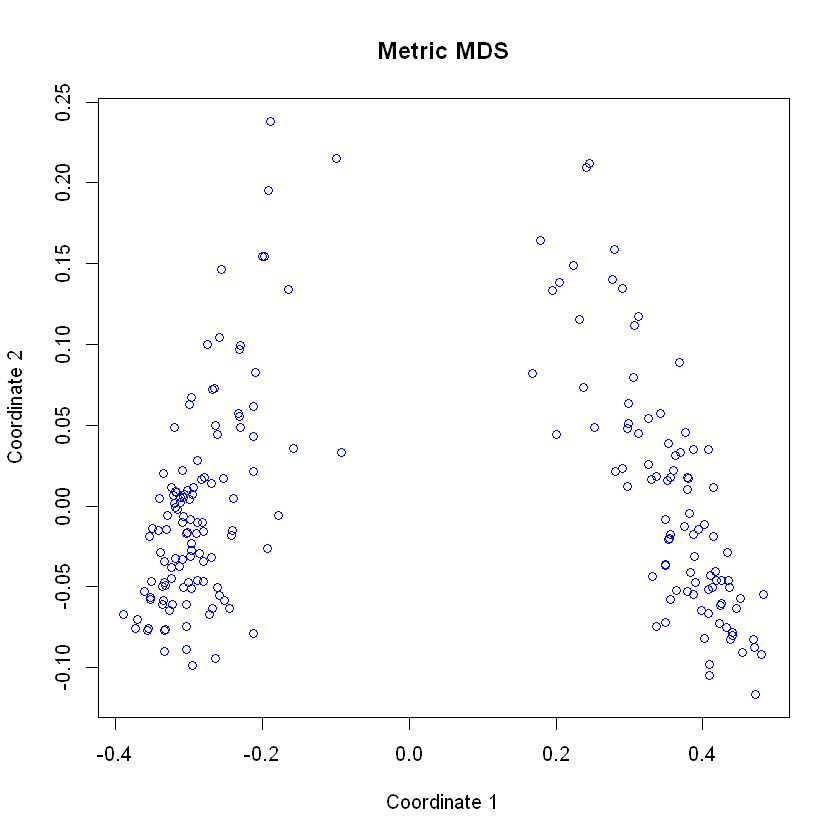

In [78]:
DISS = sqrt(1-RFproxTotal) #la matrice de dissimilarité de la random forest
MDS = cmdscale(DISS,eig=TRUE, k=2)
x <- MDS$points[,1]
y <- MDS$points[,2]
plot(x, y, xlab="Coordinate 1", ylab="Coordinate 2", 
  main="Metric MDS", col = "blue")